### Advanced Machine Learning Technologies. Autumn 2022.
### TASK 2. Sorokin Mikhail group J42322c.

In [1]:
#I took this dataset https://www.kaggle.com/datasets/joshmcadams/oranges-vs-grapefruit

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("citrus.csv")
data.head(10)

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9
5,orange,4.59,95.86,142,100,2
6,orange,4.64,97.94,156,85,2
7,orange,4.65,98.50,142,74,2
8,orange,4.68,100.20,159,90,16
9,orange,4.69,100.31,161,76,6


In [4]:
label_mapping = {'orange': 0, 'grapefruit': 1}
data['name'] = data['name'].replace(label_mapping)
data

,name,diameter,weight,red,green,blue
0,0,2.96,86.76,172,85,2
1,0,3.91,88.05,166,78,3
2,0,4.42,95.17,156,81,2
3,0,4.47,95.60,163,81,4
4,0,4.48,95.76,161,72,9
...,...,...,...,...,...,...
9995,1,15.35,253.89,149,77,20
9996,1,15.41,254.67,148,68,7
9997,1,15.59,256.50,168,82,20
9998,1,15.92,260.14,142,72,11


In [5]:
y = data['name']
X = data.drop('name', axis=1)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1234)

In [8]:
# I'll try the LogisticRegression model first
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

lr_acc = lr_model.score(X_test, y_test)

print("Accuracy:", lr_acc)

Accuracy: 0.9396666666666667


In [9]:
from catboost import CatBoostClassifier

In [10]:
# Then CatBoostClassifier model
cb_model= CatBoostClassifier(iterations=1000, learning_rate=0.3)
cb_model.fit(X_train, y_train,eval_set=(X_test, y_test))

0:	learn: 0.3952304	test: 0.3984701	best: 0.3984701 (0)	total: 145ms	remaining: 2m 25s
1:	learn: 0.2779353	test: 0.2829127	best: 0.2829127 (1)	total: 152ms	remaining: 1m 15s
2:	learn: 0.2206575	test: 0.2285569	best: 0.2285569 (2)	total: 157ms	remaining: 52.2s
3:	learn: 0.2013297	test: 0.2085638	best: 0.2085638 (3)	total: 162ms	remaining: 40.2s
4:	learn: 0.1882702	test: 0.1980669	best: 0.1980669 (4)	total: 165ms	remaining: 32.9s
5:	learn: 0.1817761	test: 0.1910762	best: 0.1910762 (5)	total: 169ms	remaining: 28s
6:	learn: 0.1757434	test: 0.1848690	best: 0.1848690 (6)	total: 173ms	remaining: 24.5s
7:	learn: 0.1690371	test: 0.1786737	best: 0.1786737 (7)	total: 175ms	remaining: 21.7s
8:	learn: 0.1603801	test: 0.1717813	best: 0.1717813 (8)	total: 178ms	remaining: 19.6s
9:	learn: 0.1579202	test: 0.1707429	best: 0.1707429 (9)	total: 181ms	remaining: 17.9s
10:	learn: 0.1566097	test: 0.1703109	best: 0.1703109 (10)	total: 183ms	remaining: 16.5s
11:	learn: 0.1544356	test: 0.1690588	best: 0.1690588

In [11]:
cb_model.best_score_

{'learn': {'Logloss': 0.008283739362444196},
 'validation': {'Logloss': 0.04771493015838959}}

### Now lets try some feature evaluations using eli5, shap and lime.

#### eli5:

In [12]:
import eli5
from eli5.sklearn import PermutationImportance

In [13]:
# For LogisticRegression model
perm = PermutationImportance(lr_model, random_state=1234).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=['diameter','weight','red','green','blue'])

Weight,Feature
0.5529 ± 0.0146,diameter
0.1041 ± 0.0129,weight
0.0427 ± 0.0101,green
0.0299 ± 0.0056,blue
0.0141 ± 0.0038,red


In [14]:
# For CatBoostClassifier model
perm = PermutationImportance(cb_model, random_state=1234).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=['diameter','weight','red','green','blue'])

Weight,Feature
0.5934 ± 0.0090,diameter
0.2567 ± 0.0057,weight
0.0100 ± 0.0019,green
0.0059 ± 0.0025,blue
0.0017 ± 0.0025,red


In [15]:
# By the eli5 evaluations it is clear than diameter of the citrus is more important towards categorizing if it is orange or grapefruit.
# The following 2nd important parameter is weight.
# Colour rgb palette seems to be the least important feature.

#### shap:

In [16]:
import shap

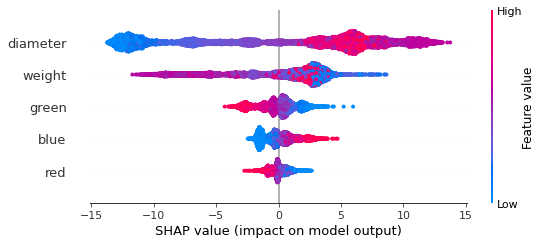

In [17]:
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(X)
shap.initjs()
#shap.force_plot(explainer.expected_value[1], shap_values[1], X)
shap.summary_plot(shap_values, X, feature_names=['diameter','weight','red','green','blue'])

In [23]:
shap.force_plot(explainer.expected_value, shap_values[1], X[1], feature_names=['diameter','weight','red','green','blue'])

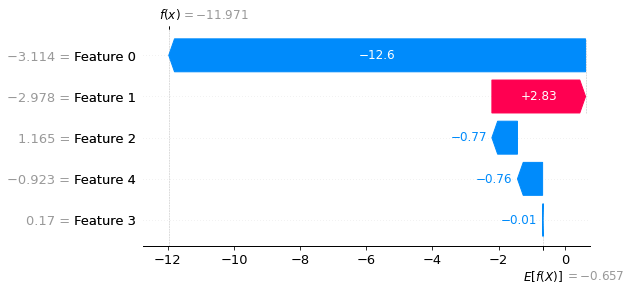

In [25]:
waterfall_shap_values = explainer(X)
shap.plots.waterfall(waterfall_shap_values[1,:])

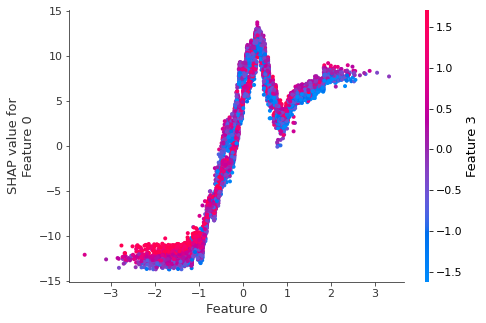

In [28]:
shap.dependence_plot("Feature 0", shap_values, X)

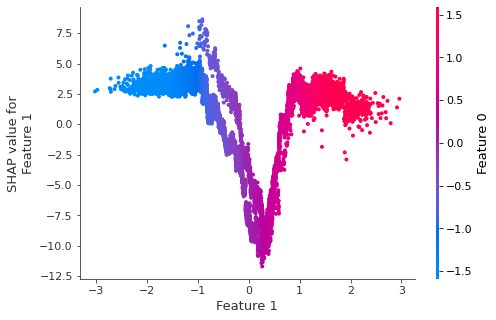

In [29]:
shap.dependence_plot("Feature 1", shap_values, X)

In [ ]:
# SHAP library shows great representations of the features and how they affect the target
# by different angles. It confirms the importance of diameter and weight for citrus in our case.

#### lime:

In [30]:
import lime

In [34]:
lime_expl = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=['diameter','weight','red','green','blue'],
                                                   class_names=[0, 1],
                                                   discretize_continuous=True)

In [54]:
# See probabilities for the 3rd fruit
cb_model.predict_proba(X_test[2])

array([0.01269203, 0.98730797])

In [55]:
# Compare to the predictions of lime and feature important graphs
exp = lime_expl.explain_instance(X_test[2], lambda x: cb_model.predict_proba(x))
exp.show_in_notebook(show_table=True)

In [ ]:
# As can be seen lime works just as fine as previous techniques. Diameter and weight are still MUCH more important than a colour.

### Conclusion

In [ ]:
# Some feature importance techniques were applied to the model. They allow a good understanding of the feature
# interpretability. eli5, shap, lime all help better understand the nature of our dataset by analysing features.
# For the choosen case in predicting citruses, diameter was the most important feature and weight comes second.
# It happens colour does not play a big role this time.